___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

<h1 style="text-align: center;">Deep Learning<br><br>Assignment-2 (CNN)<br><br>Image Classification with CNN<br><h1>

# Task and Dataset Info

Welcome to second assignment of Deep learning lesson. Follow the instructions and complete the assignment.

**Build an image classifier with Convolutional Neural Networks for the Fashion MNIST dataset. This data set includes 10 labels of different clothing types with 28 by 28 *grayscale* images. There is a training set of 60,000 images and 10,000 test images.**

    Label	Description
    0	    T-shirt/top
    1	    Trouser
    2	    Pullover
    3	    Dress
    4	    Coat
    5	    Sandal
    6	    Shirt
    7	    Sneaker
    8	    Bag
    9	    Ankle boot

# Import Libraries

## colab Package Update

⚠️ **need to restart**

In [1]:
# !pip install -Uq scikeras[tensorflow] # Causes tensorflow to update.
!pip install -Uq matplotlib  matplotlib-dashboard seaborn scikit-plot tensorflow-addons==0.19.0 

- https://github.com/tensorflow/addons#python-op-compatibility-matrix

# Import Libraries

## Colab-only auth for this notebook and the TPU

In [ ]:
import os
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
    from google.colab import auth
    # Authenticates the Colab machine and also the TPU using your
    # credentials so that they can access your private GCS buckets.
    auth.authenticate_user()

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## TPU or GPU detection

In [ ]:
import tensorflow as tf

print("Tensorflow version \t\t:" + tf.__version__)

# print("Available devices:")
# for i, device in enumerate(tf.config.list_logical_devices()):
#     print("%d) %s" % (i, device))

# check if tensorflow see the GPU
# tf.test.gpu_device_name()

print("Num physical_GPUs Available\t:", len(tf.config.list_physical_devices('GPU')))
print("Num physical_CPUs Available\t:", len(tf.config.list_physical_devices('CPU')))
print()
print("Num logical_GPUs Available\t:", len(tf.config.list_logical_devices('GPU')))
print("Num logical_CPUs Available\t:", len(tf.config.list_logical_devices('CPU')))

Tensorflow version 		:2.11.0
Num physical_GPUs Available	: 1
Num physical_CPUs Available	: 1

Num logical_GPUs Available	: 1
Num logical_CPUs Available	: 1


In [ ]:
import tensorflow as tf

try:
    # resolver = tf.distribute.cluster_resolver.TPUClusterResolver() 
    # tf.config.experimental_connect_to_cluster(resolver)
    # tf.tpu.experimental.initialize_tpu_system(resolver)
    # strategy = tf.distribute.TPUStrategy(resolver)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)    
    print('Running on TPU ', tpu.master(), len(tf.config.list_logical_devices('TPU')))
    
except ValueError:
    # If there's a GPU avaiable, to use the GPU, otherwise, using the CPU instead.
    gpus = tf.config.list_logical_devices('GPU')
    if len(gpus) > 1:        
        strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])           
        print('Running on multiple GPUs ', gpus)  
    elif len(gpus) == 1:
        strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
        print('Running on single GPU ', gpus[0].name)
    else:
        strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
        print('Running on CPU')
        
print("Number of accelerators: ", strategy.num_replicas_in_sync)    

We will use the GPU Device: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]
Number of replicas: 1


In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#import warnings
#warnings.filterwarnings("ignore")
#warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)
# The style parameters control properties like the color of the background and whether a grid is enabled by default.
# sns.set_style("whitegrid")
sns.set_style("whitegrid", {'axes.grid' : False})

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Environment settings: 
# pd.set_option('display.float_format', lambda x: f'{x:.3f}')
# pd.set_option('display.float_format', lambda x: '%.4f'%x)
# pd.options.display.float_format = '{:.4f}'.format
# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)
# Set it None to display all rows in the dataframe
pd.set_option('display.max_rows', 100)

In [ ]:
import re
import random
import pathlib

from glob import glob
from matplotlib.image import imread
import scipy.stats as stats

## Parameters

In [ ]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync # Gobal batch size.
# The global batch size will be automatically sharded across all
# replicas by the tf.data.Dataset API. A single TPU has 8 cores.
# The best practice is to scale the batch size by the number of
# replicas (cores). The learning rate should be increased as well.

LEARNING_RATE = 0.01
LEARNING_RATE_EXP_DECAY = 0.6 if strategy.num_replicas_in_sync == 1 else 0.7
# Learning rate computed later as LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch
# 0.7 decay instead of 0.6 means a slower decay, i.e. a faster learnign rate.

seed = random_state = 101

print(BATCH_SIZE)
print(round(LEARNING_RATE*LEARNING_RATE_EXP_DECAY, 3))

# Recognizing and Understanding Data

**TASK 1: Run the code below to download the dataset using Keras.**

In [ ]:
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [ ]:
print("There are ", len(X_train), "images in the training dataset")     
print("There are ", len(X_test), "images in the test dataset")

There are  60000 images in the training dataset
There are  10000 images in the test dataset


In [ ]:
# Checking the shape of one image
X_train[5].shape

(28, 28)

In [ ]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

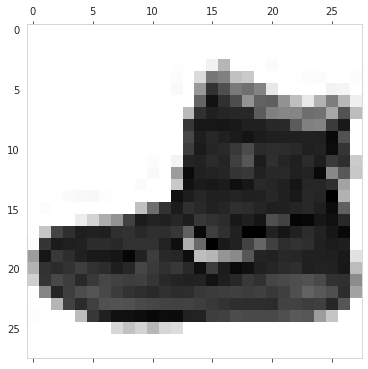

In [ ]:
# plt.imshow(X_train[0], cmap=plt.cm.Greys)
plt.matshow(X_train[0], cmap=plt.cm.binary)

In [ ]:
y_train[0]

9

In [ ]:
y_train.shape

(60000,)

In [ ]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [ ]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [ ]:
pd.Series(y_train.flatten()).value_counts().sort_index()

0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
dtype: int64

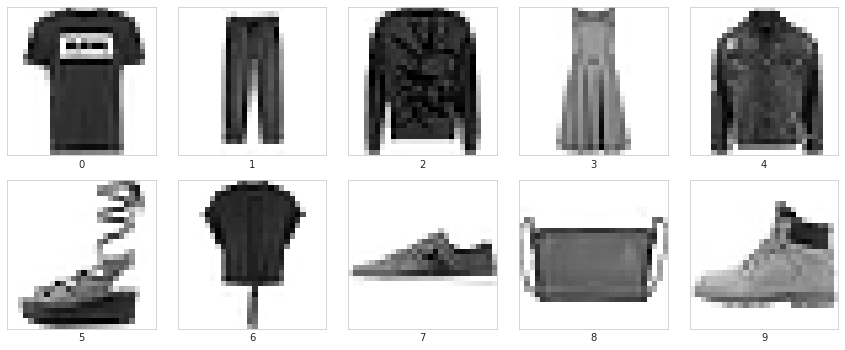

In [ ]:
plt.figure(figsize=(12,12))
for i in np.unique(y_train):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_train[y_train==i][i] / 255.0, cmap=plt.cm.binary)
    plt.grid(False)
    plt.xlabel(i)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**TASK 2: Use matplotlib to view an image from the data set. It can be any image from the data set.**

```
Label    Description
0        T-shirt/top
1        Trouser
2        Pullover
3        Dress
4        Coat
5        Sandal
6        Shirt
7        Sneaker
8        Bag
9        Ankle boot
```



In [ ]:
classes = ["T-shirt/top", "Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

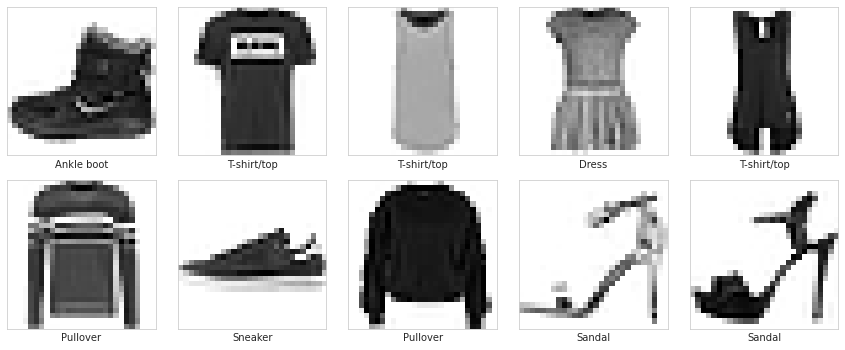

In [ ]:
plt.figure(figsize=(12,12))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.grid(False)
    plt.xlabel(classes[y_train[i]])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

# Data Preprocessing

**TASK 3: Normalize the X train and X test data by dividing by the max value of the image arrays.**

In [ ]:
X_train[0].min(), X_train[0].max()

(0, 255)

In [ ]:
# Normalize image pixels
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [ ]:
X_train[0].min(), X_train[0].max()

(0.0, 1.0)

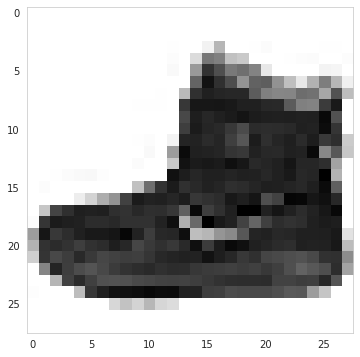

In [ ]:
plt.imshow(X_train[0], cmap=plt.cm.binary)

**Task 4: Reshape the X arrays to include a 4 dimension of the single channel. Similar to what we did for the numbers MNIST data set.**

In [ ]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [ ]:
X_train.reshape(60000, 28, 28, 1).shape

(60000, 28, 28, 1)

In [ ]:
X_train = X_train.reshape(X_train.shape[0],28, 28, 1) 
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [ ]:
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
image_shape = X_train[0].shape
image_shape

(28, 28, 1)

**TASK 5: Convert the y_train and y_test values to be one-hot encoded for categorical analysis by Keras.**

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
np.unique(y_train).size

10

In [ ]:
Y_train = to_categorical(y_train, num_classes=10) 
Y_test = to_categorical(y_test, num_classes=10)
Y_train.shape, Y_test.shape

((60000, 10), (10000, 10))

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer, LabelEncoder

lb = LabelBinarizer()
Y_train = lb.fit_transform(y_train)
Y_test  = lb.transform(y_test)

Y_train.shape, Y_test.shape

((60000, 10), (10000, 10))

In [ ]:
Y_train[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
y_train[0]

9

- https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/preprocessing/label.py#L39

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer, LabelEncoder
from sklearn.utils import column_or_1d

classes = ["T-shirt/top", "Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

class LabelEncoder(LabelEncoder):
    def fit(self, y):
        y = column_or_1d(y, warn=True)
        # self.classes_ = np.unique(y) # defaulth sorted
        self.classes_ = pd.Series(y).unique() # but we dont 
        return self

le = LabelEncoder()
le.fit(classes)

le.classes_, le.inverse_transform([y_train[0]])

(array(['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
        'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], dtype=object),
 array(['Ankle boot'], dtype=object))

# Convolutional Neural Network Modeling

In [ ]:
# !pip install tensorflow -Uq
import tensorflow as tf
# !pip install tensorflow-addons -Uq
import tensorflow_addons as tfa

from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer, LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score, roc_curve #, plot_roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import  SCORERS, precision_score, recall_score, f1_score, accuracy_score, cohen_kappa_score

# !pip install scikeras[tensorflow] -Uq
# from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop, Nadam
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
# !pip install scikit-plot -Uq
import scikitplot as skplt

## Eval Metric Convolutional Neural Network

In [ ]:
def eval_metric(model, X_train, y_train, X_test, y_test, pipe = True):
    from sklearn.metrics import confusion_matrix, classification_report
    if pipe:
        y_pred_test  = model[-1].predict(model[:-1].transform(X_test)) >= 0.5
        y_pred_train = model[-1].predict(model[:-1].transform(X_train)) >= 0.5
    else:
        y_pred_test = model.predict(X_test) >= 0.5 # model.predict_classes(X_test) for tf 2.5.0
        y_pred_train = model.predict(X_train) >= 0.5
      
    print('TEST')    
    print(confusion_matrix(y_test, y_pred_test))
    print(classification_report(y_test, y_pred_test))
    print("-------------------------------------------------------")
    print('TRAIN')
    print(confusion_matrix(y_train, y_pred_train))
    print(classification_report(y_train, y_pred_train))

In [ ]:
def plot_history(history, pipe=True):
    # Plot training results
    if pipe:
        H = history[-1].history.history
    else:
        H = history.history
    
    fig = plt.figure(figsize = (18, 7))

    plt.subplot(121)
    plt.plot(H['loss'], label = 'loss')
    plt.plot(H['val_loss'], label = 'val_loss')
    plt.grid()
    plt.legend()

    plt.subplot(122)
    plt.plot(H['recall'], label = 'recall')
    plt.plot(H['val_recall'], label = 'val_recall')
    plt.grid()
    plt.legend()

In [ ]:
def plot_metrics(history, metrics_names, pipe=True):
    colors  = plt.rcParams['axes.prop_cycle'].by_key()['color']
    if pipe:
        history = history[-1].history
    else:
        history = history

    fig = plt.figure(figsize = (14, 10))

    for n, metric in enumerate(metrics_names):
        name = str(metric).replace("_"," ").capitalize()
        plt.subplot(3, 2, n+1)
        plt.plot(history.epoch, history.history[metric], 
                 color='xkcd:dodger blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color='salmon', ls="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name, fontsize=12)
        plt.legend()
        plt.tight_layout(pad=0.3)
        if metric == 'loss':
            plt.ylim(top=plt.ylim()[1])
        else: # plt.ylim(plt.gca().get_ylim())
            plt.ylim(bottom=plt.ylim()[0])

## Create the model

**TASK 5: Use Keras to create a model consisting of at least the following layers (but feel free to experiment):**

* 2D Convolutional Layer, filters=28 and kernel_size=(3,3)
* Pooling Layer where pool_size = (2,2) strides=(1,1)

* Flatten Layer
* Dense Layer (128 Neurons, but feel free to play around with this value), RELU activation

* Final Dense Layer of 10 Neurons with a softmax activation

**Then compile the model with these parameters: loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']**

In [ ]:
print("Model Defined Shape: ", X_train.shape, image_shape)        # Input Layer Shape

# way-1
def build_classifier_model(
        input_shape: int = X_train.shape[1:],
        units:int        = 128,
) -> tf.keras.models.Model:    
    import tensorflow as tf    
    
    model = Sequential()
    model.add(Conv2D(filters=28, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1)))

    model.add(Flatten())
    model.add(Dense(units, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(optimizer = "rmsprop", 
                  loss = 'categorical_crossentropy', 
                  metrics = ['accuracy', 'Recall'], 
                  # weighted_metrics=['Recall']
                  )
    return model

Model Defined Shape:  (60000, 28, 28, 1) (28, 28, 1)


In [ ]:
print("Model Defined Shape: ", X_train.shape, image_shape)        # Input Layer Shape

# way-2
def build_classifier_model_cnn(
        input_shape: int = X_train.shape[1:],
        units:int      = 128,
) -> tf.keras.models.Model:
    import tensorflow as tf  
    
    inputs = tf.keras.layers.Input(shape=input_shape )
    x = tf.keras.layers.Conv2D(filters=28, kernel_size=(3,3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units, activation=tf.nn.relu)(x) 
    outputs  = tf.keras.layers.Dense(10, activation=tf.nn.softmax)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="classifier_model") 

    precision_at_recall = tf.keras.metrics.PrecisionAtRecall(recall=0.8)

    model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001), 
                  loss = tf.keras.losses.CategoricalCrossentropy(), 
                  metrics = ['accuracy', tf.keras.metrics.Recall()], 
                  # weighted_metrics = [tf.keras.metrics.Recall()] 
                  )
    return model

Model Defined Shape:  (60000, 28, 28, 1) (28, 28, 1)


##  Model Training 

**TASK 6: Train/Fit the model to the x_train set by using EarlyStop. Amount of epochs is up to you.**

In [ ]:
from sklearn.pipeline import Pipeline

tf.keras.backend.clear_session()

with strategy.scope():  
    model = build_classifier_model()
    display(model.summary())

    pipe_cnn1 = Pipeline([
        ("cnn", model)
    ])
    pipe_cnn1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 28)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 17500)             0         
                                                                 
 dense (Dense)               (None, 128)               2240128   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 2,241,698
Trainable params: 2,241,698
Non-trainable params: 0
______________________________________________

None

Pipeline(steps=[('cnn',
                 <keras.engine.sequential.Sequential object at 0x7f734a40a310>)])

In [ ]:
from sklearn.pipeline import Pipeline

tf.keras.backend.clear_session()

with strategy.scope():  
    model = build_classifier_model_cnn()
    display(model.summary())

    pipe_cnn2 = Pipeline([
        ("cnn", model)
    ])
    pipe_cnn2

Model: "classifier_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 28)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 17500)             0         
                                                                 
 dense (Dense)               (None, 128)               2240128   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                  

None

Pipeline(steps=[('cnn',
                 <keras.engine.functional.Functional object at 0x7f734a28da60>)])

In [ ]:
from collections import Counter

counter = Counter(y_train)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}  
class_weights

In [ ]:
from sklearn.utils import class_weight

class_weights = dict(
    zip(np.unique(y_train),
        class_weight.compute_class_weight(
            class_weight = 'balanced',
            classes = np.unique(y_train), 
            y = y_train)
))
print(class_weights)

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0}


In [ ]:
early_stop = EarlyStopping(monitor='val_recall', mode="max",
                           verbose = 1, patience = 15, restore_best_weights = True)

In [ ]:
%%time
history = pipe_cnn1.fit(X = X_train, y = Y_train, cnn__validation_data = (X_test,Y_test), #cnn__validation_split = 0.1,
                    cnn__batch_size = 32, cnn__epochs = 1000, cnn__verbose = 0, cnn__callbacks=[early_stop], cnn__class_weight=class_weights)

Restoring model weights from the end of the best epoch: 62.
Epoch 77: early stopping
CPU times: user 8min 43s, sys: 58.4 s, total: 9min 42s
Wall time: 8min 4s


In [ ]:
history_df = pd.DataFrame(history[-1].history.history)
history_df.index += 1
history_df.tail(16)

,loss,accuracy,recall,val_loss,val_accuracy,val_recall
62,0.001,1.000,1.000,1.449,0.915,0.915
63,0.000,1.000,1.000,1.475,0.914,0.914
64,0.002,0.999,0.999,1.525,0.910,0.910
65,0.001,1.000,1.000,1.455,0.910,0.910
66,0.001,1.000,1.000,1.578,0.908,0.908
67,0.003,0.999,0.999,1.551,0.905,0.905
68,0.002,1.000,1.000,1.425,0.913,0.913
69,0.001,1.000,1.000,1.444,0.914,0.913
70,0.002,1.000,1.000,1.371,0.910,0.910
71,0.002,0.999,0.999,1.645,0.911,0.911


In [ ]:
# save model permanently and check
# model.save_weights('first_try.h5')
pipe_cnn1[-1].save('/content/drive/MyDrive/fashion_mnist1.h5')

**TASK 7: Plot values of metrics you used in your model.**

In [ ]:
pipe_cnn1[-1].metrics_names

['loss', 'accuracy', 'recall']

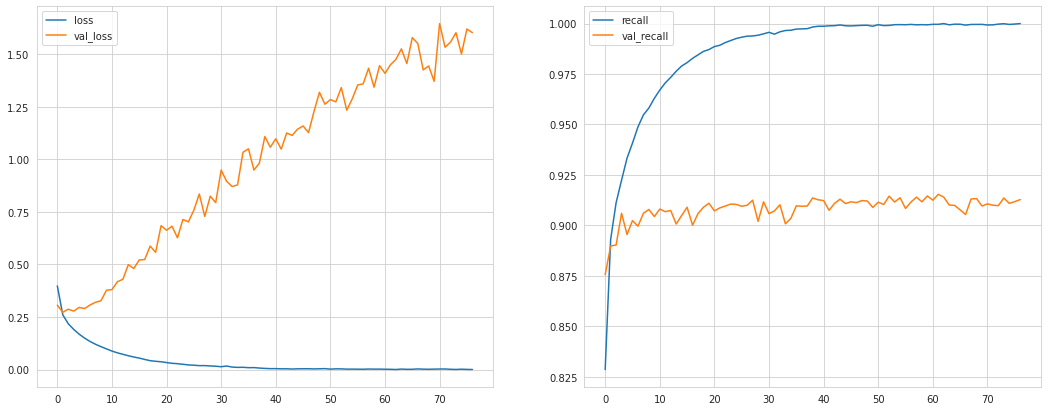

In [ ]:
# Plot training results
plot_history(history)

# Modelling-2

In [ ]:
print("Model Defined Shape: ", X_train.shape, image_shape)        # Input Layer Shape

# way-1
def build_classifier_model(
        input_shape: int = X_train.shape[1:],
        units:int      = 128,
) -> tf.keras.models.Model:    
    import tensorflow as tf    
    
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=(4,4), strides=(1,1), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=64, kernel_size=(4,4), strides=(1,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(10, activation='softmax'))
    
    model.compile(optimizer = "rmsprop", 
                  loss = 'categorical_crossentropy', 
                  metrics = ['accuracy', 'Recall'], 
                  # weighted_metrics=['Recall']
                  )
    return model

Model Defined Shape:  (60000, 28, 28, 1) (28, 28, 1)


In [ ]:
tf.keras.backend.clear_session()

model = build_classifier_model()
display(model.summary())

pipe_cnn2 = Pipeline([
    ("cnn", model)
])
pipe_cnn2

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 64)        1088      
                                                                 
 batch_normalization (BatchN  (None, 25, 25, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 25, 25, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 64)       256       
 hNormalization)                                                 
                                                        

None

Pipeline(steps=[('cnn',
                 <keras.engine.sequential.Sequential object at 0x7f7335f4b9d0>)])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode="min",
                           verbose = 1, patience = 5, restore_best_weights = True)

In [ ]:
%%time
history = pipe_cnn2.fit(X = X_train, y = Y_train, cnn__validation_data = (X_test,Y_test), #cnn__validation_split = 0.1,
                    cnn__batch_size = 32, cnn__epochs = 1000, cnn__verbose = 0, cnn__callbacks=[early_stop], cnn__class_weight=class_weights)

Restoring model weights from the end of the best epoch: 8.
Epoch 13: early stopping
CPU times: user 6min 19s, sys: 10.4 s, total: 6min 29s
Wall time: 6min 19s


In [ ]:
history_df = pd.DataFrame(history[-1].history.history)
history_df.index += 1
history_df.tail(6)

,loss,accuracy,recall,val_loss,val_accuracy,val_recall
8,0.162,0.940,0.934,0.226,0.926,0.922
9,0.148,0.947,0.941,0.258,0.914,0.911
10,0.134,0.951,0.947,0.255,0.921,0.918
11,0.122,0.956,0.952,0.263,0.923,0.920
12,0.112,0.960,0.956,0.366,0.901,0.900
13,0.104,0.963,0.960,0.276,0.926,0.923


In [ ]:
# save model permanently and check
pipe_cnn2[-1].save('/content/drive/MyDrive/fashion_mnist2.h5')

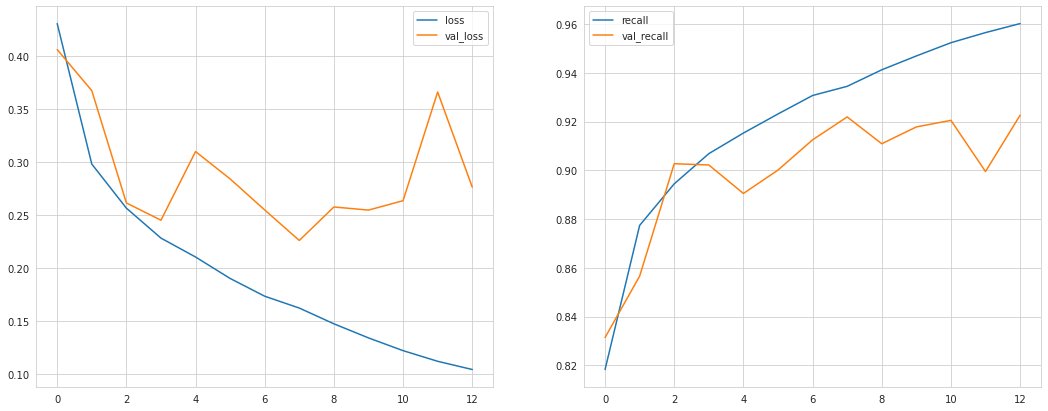

In [ ]:
plot_history(history)

# Compare and Select Models

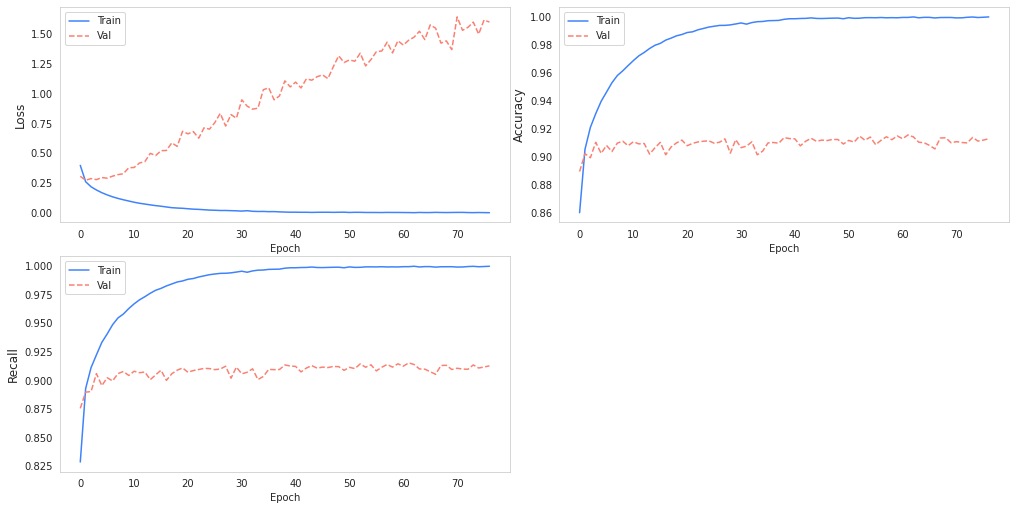

In [ ]:
plot_metrics(pipe_cnn1, pipe_cnn1[-1].metrics_names)

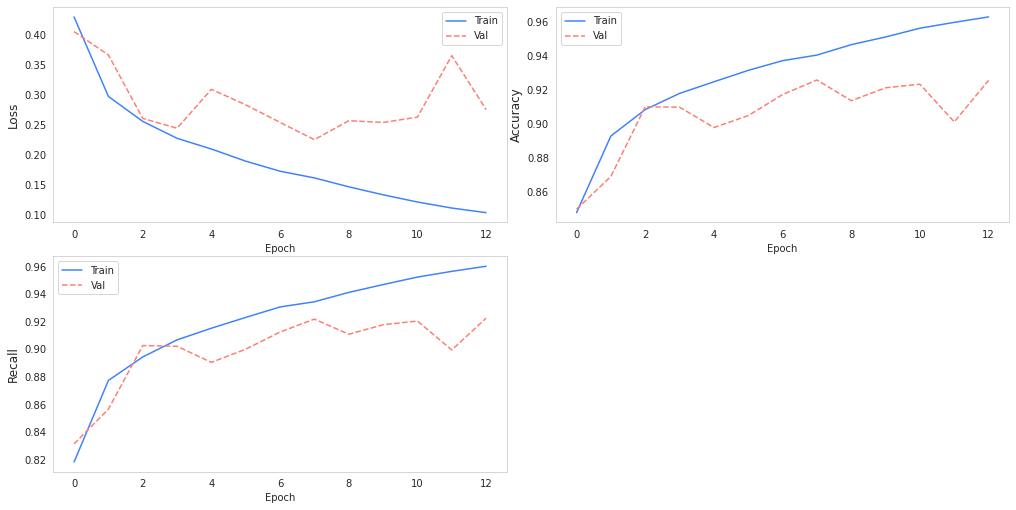

In [ ]:
plot_metrics(pipe_cnn2, pipe_cnn2[-1].metrics_names)

## Model Evaluation

**TASK 8: Show the accuracy,precision,recall,f1-score the model achieved on the x_test data set. Keep in mind, there are quite a few ways to do this, but we recommend following the same procedure we showed in the MNIST lecture.**

- https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/

In [ ]:
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, cohen_kappa_score

In [ ]:
pipe_cnn1[-1].evaluate(
    X_test, Y_test, 
    return_dict=True, verbose=0)

{'loss': 1.4492137432098389,
 'accuracy': 0.9154999852180481,
 'recall': 0.9154000282287598}

In [ ]:
pipe_cnn2[-1].evaluate(
    X_test, Y_test, 
    return_dict=True, verbose=0)

{'loss': 0.22601447999477386,
 'accuracy': 0.9258000254631042,
 'recall': 0.9218999743461609}

In [ ]:
# predict probabilities 
y_pred_prob_test  = pipe_cnn2.predict(X_test, verbose=0)
y_pred_prob_train = pipe_cnn2.predict(X_train, verbose=0)

y_pred_prob_test.shape, y_pred_prob_train.shape

((10000, 10), (60000, 10))

In [ ]:
# predict crisp classes 
y_pred_test  = np.argmax(pipe_cnn2.predict(X_test, verbose=0), axis=1)
y_pred_train = np.argmax(pipe_cnn2.predict(X_train, verbose=0), axis=1)

y_pred_test.shape, y_pred_train.shape

((10000,), (60000,))

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred_test)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred_test, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred_test, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred_test, average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.925800
Precision: 0.926935
Recall: 0.925800
F1 score: 0.926160


In [ ]:
# kappa
kappa = cohen_kappa_score(y_test, y_pred_test)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred_prob_test, multi_class='ovr')
print('ROC AUC: %f' % auc)

Cohens kappa: 0.917556
ROC AUC: 0.995419


In [ ]:
print(classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


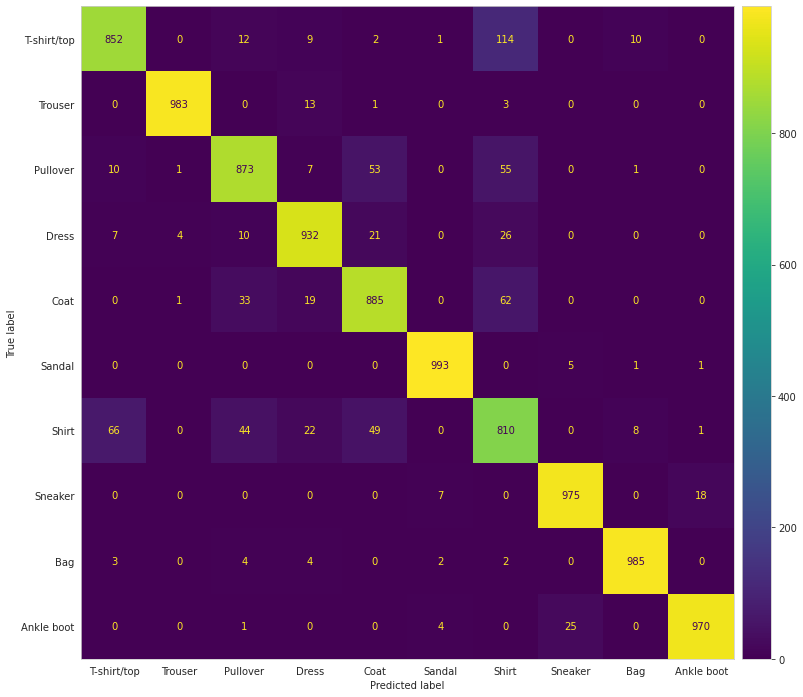

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(
    y_test, y_pred_test,
    # labels=classes
)

cmp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=classes
)

fig, ax = plt.subplots(figsize=(12, 12))

# Deactivate default colorbar
cmp.plot(ax=ax, colorbar=False)
plt.grid(False)

# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+.01, ax.get_position().y0, .033, ax.get_position().height])
plt.colorbar(cmp.im_, cax=cax)

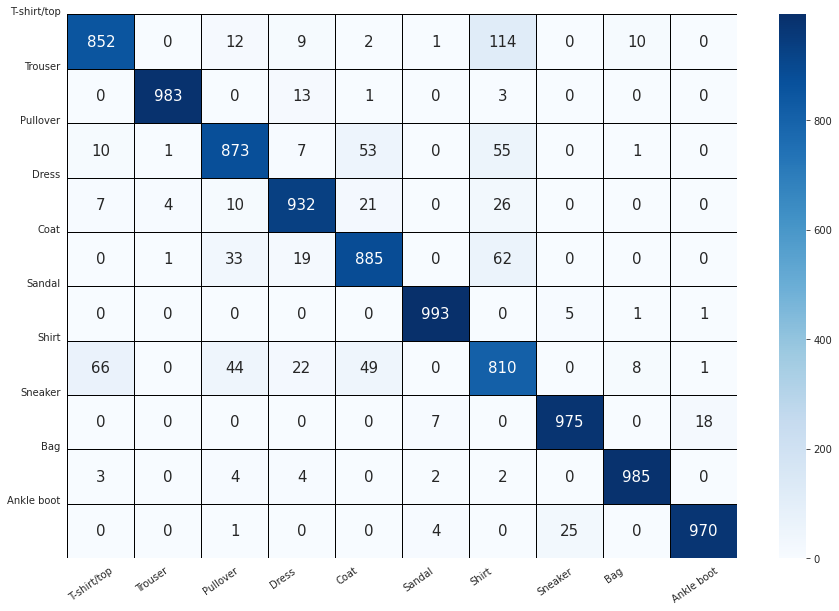

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(
    confusion_matrix(y_test, y_pred_test), 
    annot=True, cmap="Blues", lw=.5, linecolor='black', 
    fmt='g', annot_kws = {"size": 15}
)
plt.xticks(range(len(classes)), classes, rotation=35, ha='left');
plt.yticks(range(len(classes)), classes, rotation=0, ha='right', va='baseline');

In [ ]:
(y_test != y_pred_test).sum()

742

In [ ]:
print(classification_report(y_test, y_pred_test,))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88      1000
           1       0.99      0.98      0.99      1000
           2       0.89      0.87      0.88      1000
           3       0.93      0.93      0.93      1000
           4       0.88      0.89      0.88      1000
           5       0.99      0.99      0.99      1000
           6       0.76      0.81      0.78      1000
           7       0.97      0.97      0.97      1000
           8       0.98      0.98      0.98      1000
           9       0.98      0.97      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



## Prediction

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/fashion_mnist2.h5')

In [ ]:
X_test[0].shape

(28, 28, 1)

In [ ]:
np.expand_dims(X_test[0],axis=0).shape, X_test[0].reshape(1, 28, 28, 1).shape

((1, 28, 28, 1), (1, 28, 28, 1))

In [ ]:
pred_proba = model.predict(np.expand_dims(X_test[0], axis=0))
pred_proba

1/1 [==============================] - 0s 255ms/step


array([[9.5138262e-07, 3.6289778e-06, 2.4593643e-07, 2.8329498e-07,
        1.0098020e-06, 1.5076815e-06, 2.0998725e-06, 2.9028957e-05,
        5.9820884e-08, 9.9996114e-01]], dtype=float32)

In [ ]:
pred = np.argmax(pred_proba)
pred

9

In [ ]:
classes[pred], le.inverse_transform([pred])

('Ankle boot', array(['Ankle boot'], dtype=object))

In [ ]:
X_test[0].squeeze().shape, X_test[0].reshape(28, 28).shape

((28, 28), (28, 28))

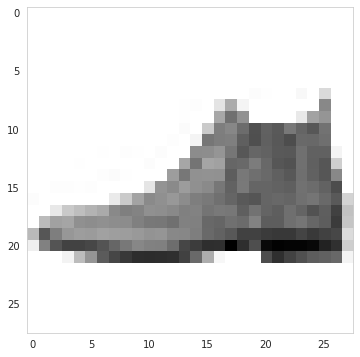

In [ ]:
plt.imshow(X_test[0].squeeze(), cmap=plt.cm.binary)

# End of Assignment

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___